# Analyze Participants' Answers in Pilot 2 Study

In [28]:
import MySQLdb
import sshtunnel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import Lasso
from ast import literal_eval
import matplotlib.pyplot as plt
import glob
from pathlib import Path
from utils import *
from tabulate import tabulate
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [23]:
sshtunnel.SSH_TIMEOUT = 5.0
sshtunnel.TUNNEL_TIMEOUT = 5.0

with sshtunnel.SSHTunnelForwarder(
    ('ssh.pythonanywhere.com'),
    ssh_username='Grawi', ssh_password='midgeq-xikFah-gukpu7',
    remote_bind_address=('Grawi.mysql.pythonanywhere-services.com', 3306)
) as tunnel:
    print("Successfully connected to Pythonanywhere")
    connection = MySQLdb.connect(
        user='Grawi',
        passwd='david2202087',
        host='127.0.0.1', port=tunnel.local_bind_port,
        db='Grawi$Interactive_quiz_database',
    )
    # Do stuff
    print("Successfully connected to database")
    
    try:
        cursor = connection.cursor()
        query = "SELECT * FROM pilot_2 where submit_time>='2024-03-01';"
        df = pd.read_sql(query, connection)
        print(f"Data read finished, length {len(df)}")
    except Exception as e:
        print("Error:", e)
    
    finally:
        # Close the cursor and connection
        cursor.close()
        connection.close()

df["pilot_2_answers"] = df["pilot_2_answers"].map(literal_eval)
df['submit_time'] = pd.to_datetime(df['submit_time'])
df = df.loc[df["participantId"] != "testId"]
df.head()

2024-03-07 10:30:32,115| ERROR   | Password is required for key /Users/guodawei/.ssh/id_rsa


Successfully connected to Pythonanywhere
Successfully connected to database
Data read finished, length 199


,participantId,assignmentId,projectId,attention_passed,total_time,pilot_2_answers,ideology_label,bot_detected,submit_time,identity_choices,ideologies,reason
0,009FBF921182482EB3B2C7C66D5DF395,758d7145-78b7-4f19-9552-d79fea8095d0,464ae45d-fe95-4a79-a013-b4270d3e1513,1,245.916,"[{'type': 'design', 'index': 9, 'answer': '0'}...",1.5,None,2024-03-07 01:36:00,None,None,None
1,00D808BCA2364DC0A9D86AAFCCF3B83E,fa8f8922-8a84-4980-bcb0-cbed2152156f,464ae45d-fe95-4a79-a013-b4270d3e1513,1,236.468,"[{'type': 'fact', 'index': 9, 'answer': '0'}, ...",1.2,None,2024-03-07 01:26:33,None,None,None
2,01A4A3D8DB3E44BAA3F9DE88CB8BE7F8,e3bb4a82-938a-471b-b12e-d2e17d85598e,464ae45d-fe95-4a79-a013-b4270d3e1513,0,435.348,"[{'type': 'fact', 'index': 8, 'answer': '1'}, ...",2.0,None,2024-03-07 02:00:20,None,None,None
3,02005180DD3F429DB8D8609BD1BAA324,ab515b89-f74f-4327-bd52-6e4193498df9,464ae45d-fe95-4a79-a013-b4270d3e1513,1,194.179,"[{'type': 'prediction', 'index': 4, 'answer': ...",-1.0,None,2024-03-04 01:59:06,None,None,None
4,03F53C2027DA4B6A97B25800E417927B,a7d21b2f-1050-4334-b568-1e0e028e6d90,464ae45d-fe95-4a79-a013-b4270d3e1513,1,242.079,"[{'type': 'fact', 'index': 8, 'answer': '0'}, ...",-1.0,None,2024-03-04 02:03:45,None,None,None


In [24]:
ids_attention_failed = df.loc[df['attention_passed'] == 0]["participantId"].tolist()
print(f"Participants who failed attention check: {ids_attention_failed}")
df = df.loc[df["attention_passed"] == 1]
df = df.loc[:, ["participantId", "pilot_2_answers", "ideology_label"]].set_index("participantId")

def IdeologyToNumber(ideology):
    if ideology == "Moderate":
        return 0
    elif ideology == "Somewhat Conservative":
        return 1
    elif ideology == "Conservative":
        return 2
    elif ideology == "Somewhat Liberal": 
        return -1
    elif ideology == "Liberal":
        return -2

# connect_data_csv = glob.glob('data/connect_raw_data/pilot-2-2*.csv')[0]
# df_connect = pd.read_csv(connect_data_csv).set_index("ParticipantId")
# df["connect_ideology"] = df_connect["Political Ideology"].map(IdeologyToNumber)
# print("rmse of ideology:", np.sqrt(np.mean((df["ideology_label"] - df["connect_ideology"])**2)))
df["ideology"] = df["ideology_label"]
df.drop(["ideology_label"], axis=1, inplace=True)
# df.drop(["connect_ideology", "ideology_label"], axis=1, inplace=True)
df.head()

Participants who failed attention check: ['01A4A3D8DB3E44BAA3F9DE88CB8BE7F8', '3C07AD5EA91D453AAFFA3FD5EA7F29A4', '763C34E3F4AA4ECB88CEF7B708B9A6CC', '78461A9831BC41D1863B2A949F079D40', 'FDB9DD9AACCE49AE91F4FC35298E2966']


,pilot_2_answers,ideology
participantId,,
009FBF921182482EB3B2C7C66D5DF395,"[{'type': 'design', 'index': 9, 'answer': '0'}...",1.5
00D808BCA2364DC0A9D86AAFCCF3B83E,"[{'type': 'fact', 'index': 9, 'answer': '0'}, ...",1.2
02005180DD3F429DB8D8609BD1BAA324,"[{'type': 'prediction', 'index': 4, 'answer': ...",-1.0
03F53C2027DA4B6A97B25800E417927B,"[{'type': 'fact', 'index': 8, 'answer': '0'}, ...",-1.0
06188458E16B4EC8B21EEC757742DB49,"[{'type': 'fact', 'index': 7, 'answer': '1'}, ...",1.7


In [25]:
import os
from pathlib import Path
import re
import json

folder_path = Path(os.getcwd())
pilot_2_statements_js = folder_path.parent / "app"/ "static" / "data" / "phase_2_statements.js"
with open(pilot_2_statements_js) as js:
    js_content = js.read()
    json_content = js_content.replace("\n", "").replace("/'", "'")
    json_content = json_content.lstrip("const phase_2_statements = ")
phase_2_statements = json.loads(json_content)

## 1. The Answer Patter for Each Question

In [26]:
df_exploded = df.explode(["pilot_2_answers"])
df_each = df_exploded["pilot_2_answers"].apply(pd.Series)
df_each = pd.concat([df_each, df_exploded], axis=1)
df_each = df_each.reset_index()
df_each.drop(["pilot_2_answers", "participantId"], axis=1, inplace=True)
print(df_each.groupby(["type", "index"]).size())
df_each = df_each.set_index(["type", "index"])
df_each = df_each.astype({"answer": int})
df_each.head()

type        index
design      0        96
            1        87
            2        87
            3        80
            4        86
            5        85
            6        88
            7        79
            8        80
            9        93
            10       83
            11       79
            12       90
fact        0        91
            1        96
            2        79
            3        99
            4        79
            5        97
            6        96
            7        92
            8        81
            9        86
            10       84
            11       96
            12       93
            13       96
issue       0        87
            1        76
            2        76
            3        92
            4        90
            5        81
            6        83
            7        85
            8        79
            9        78
            10       90
            11       94
            12       80
            13       9

answer  ideology
type       index                  
design     9           0       1.5
           3           0       1.5
issue      8           0       1.5
prediction 9           1       1.5
           13          1       1.5

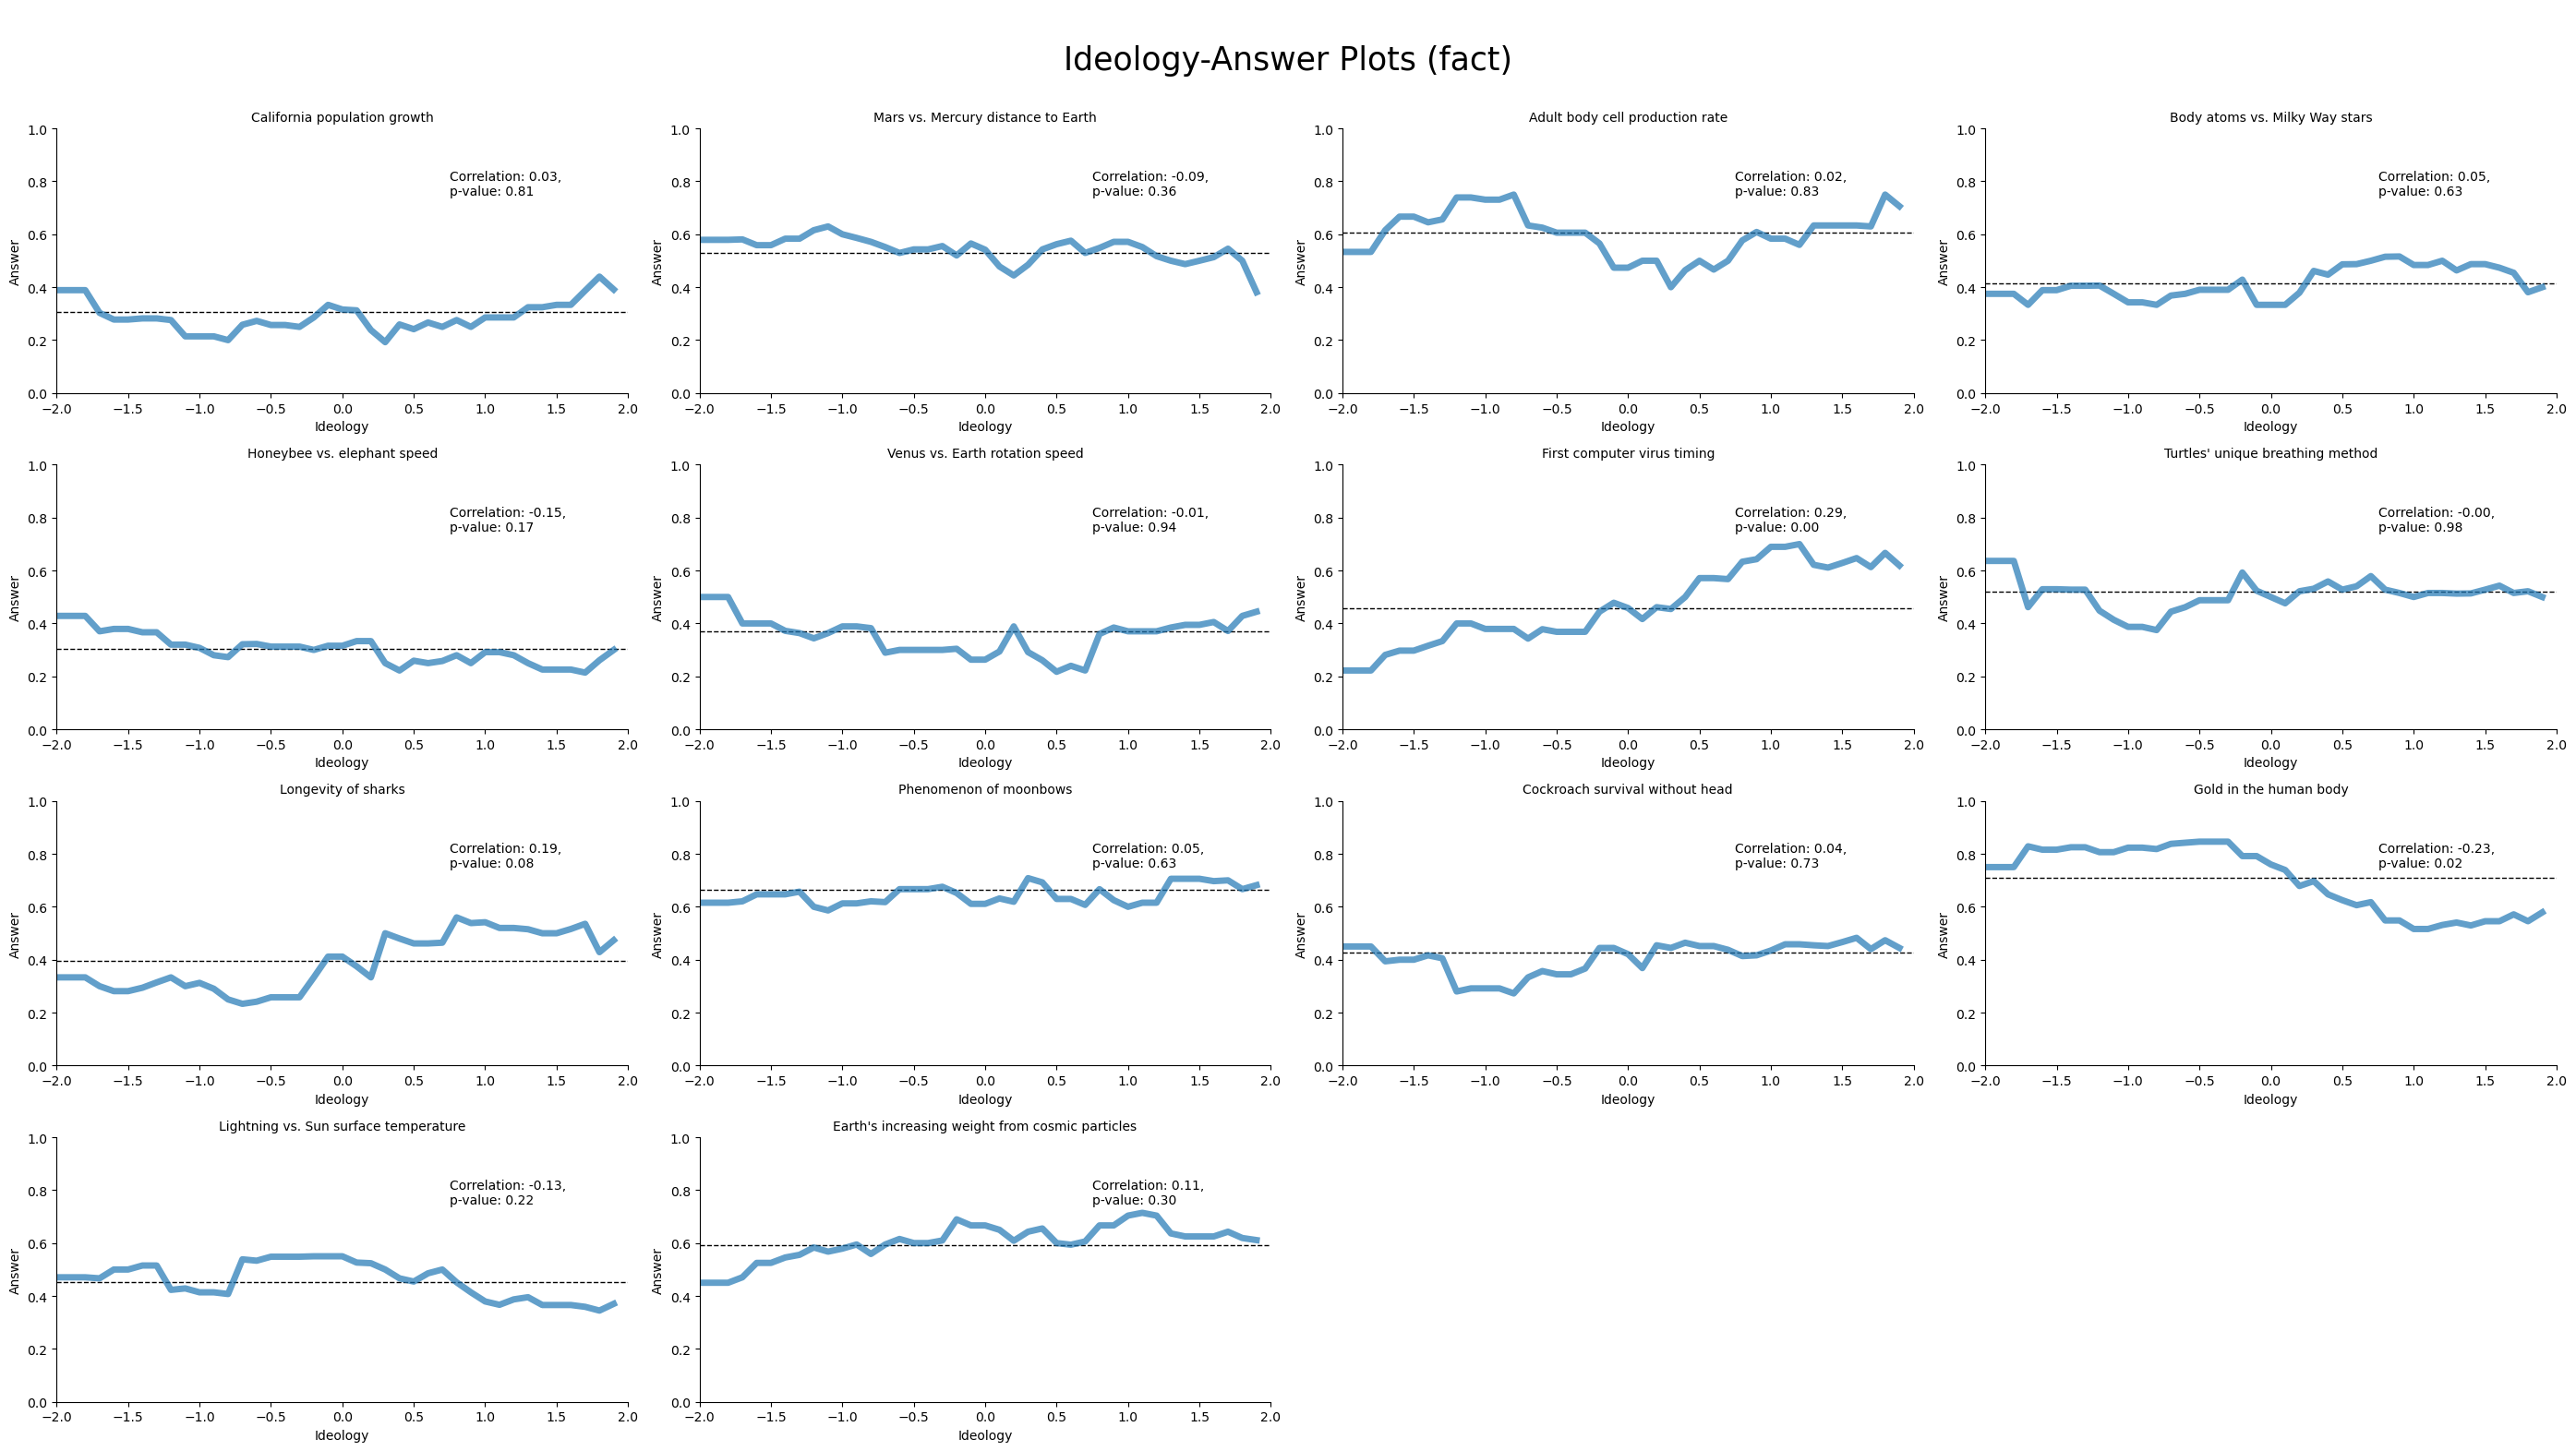

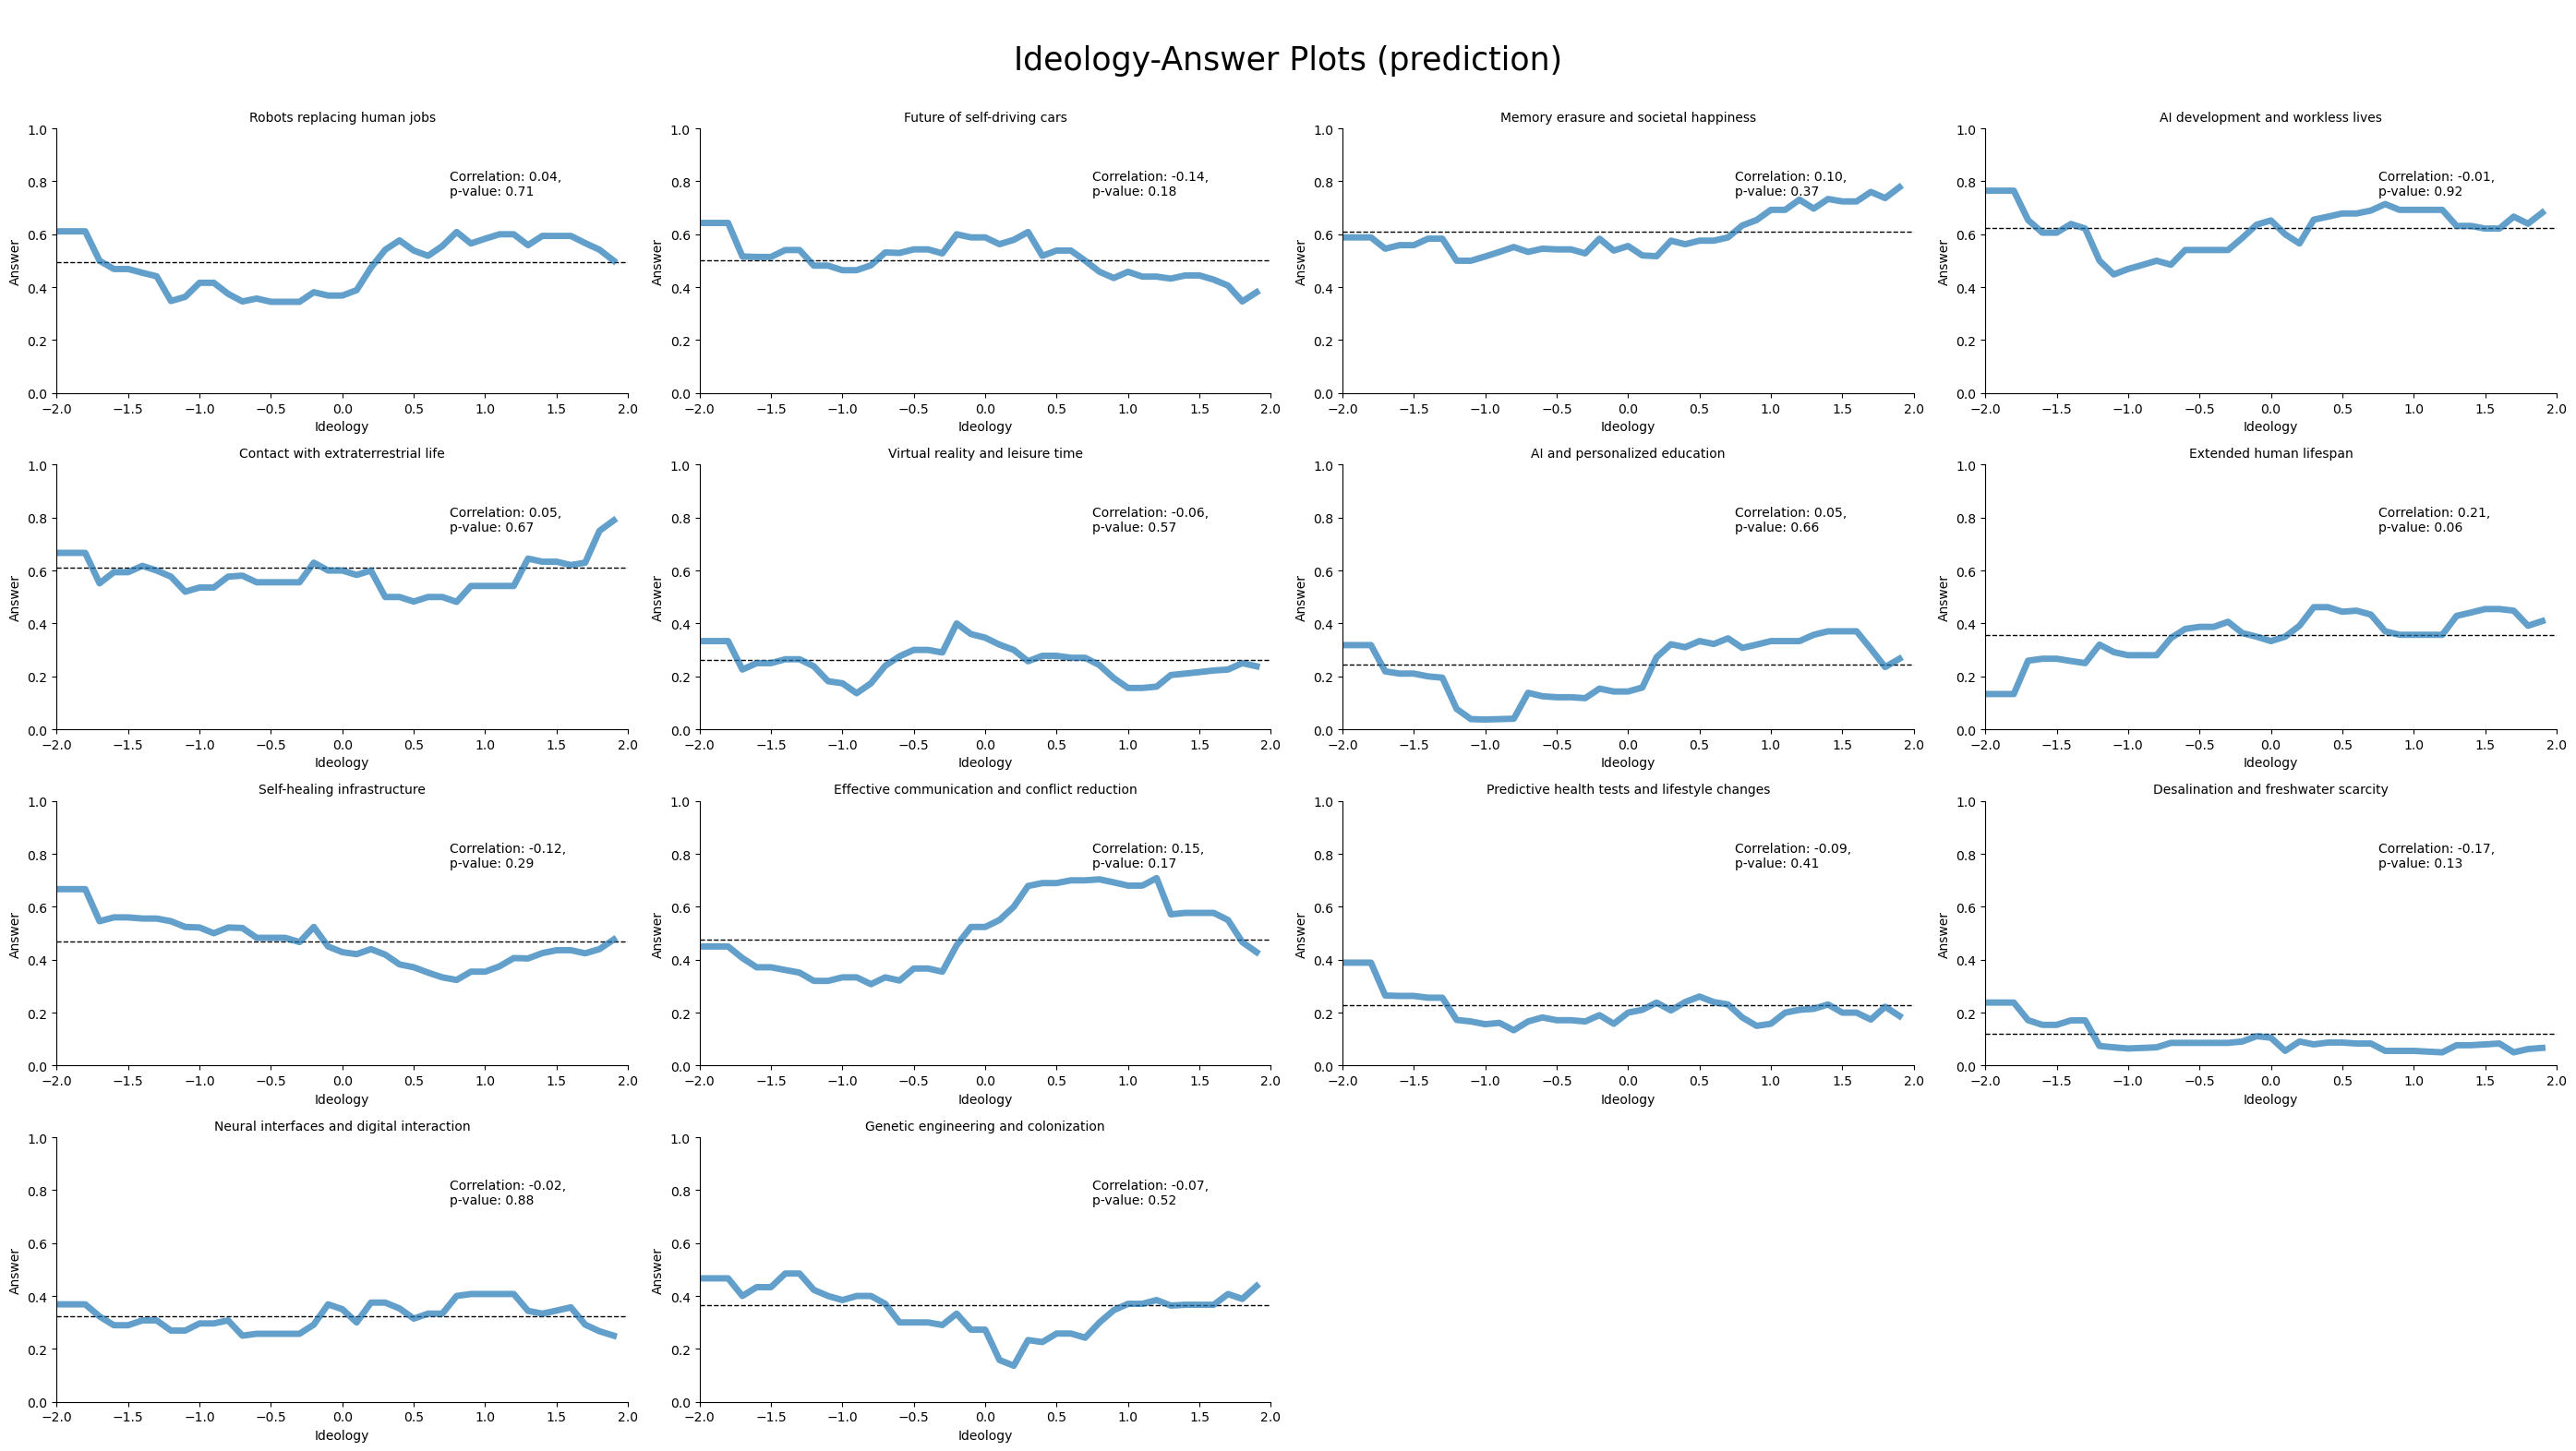

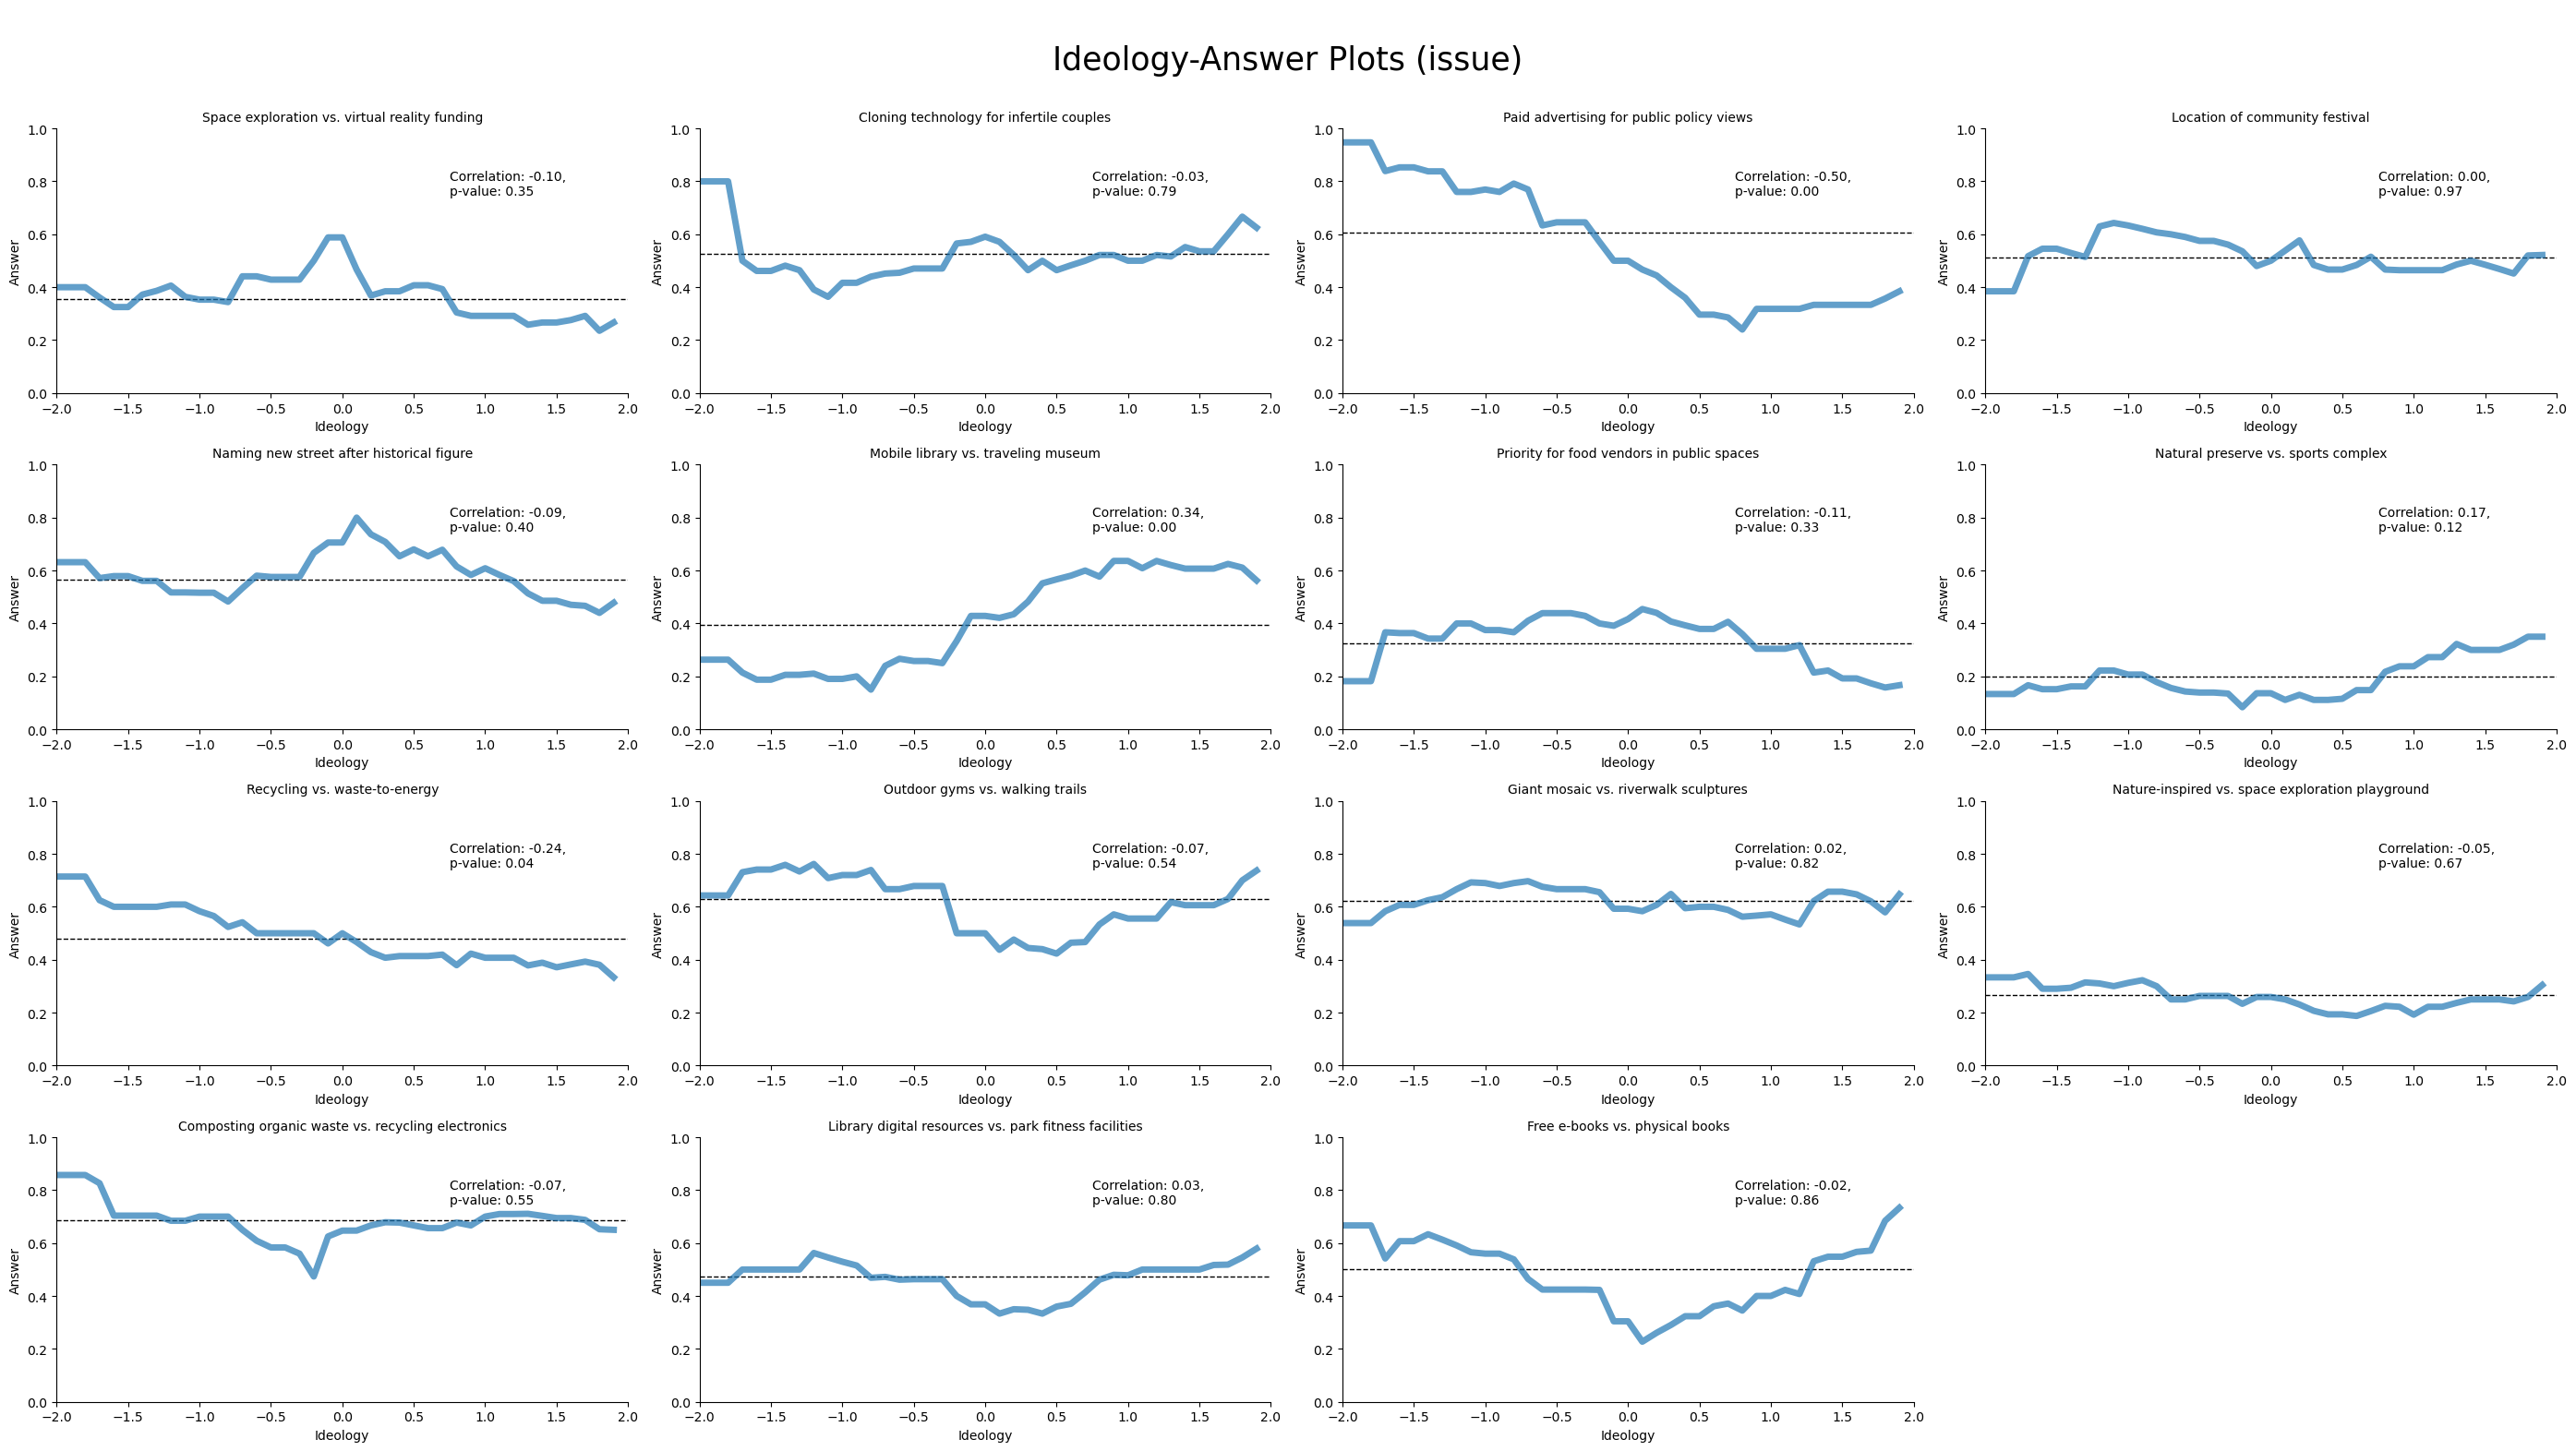

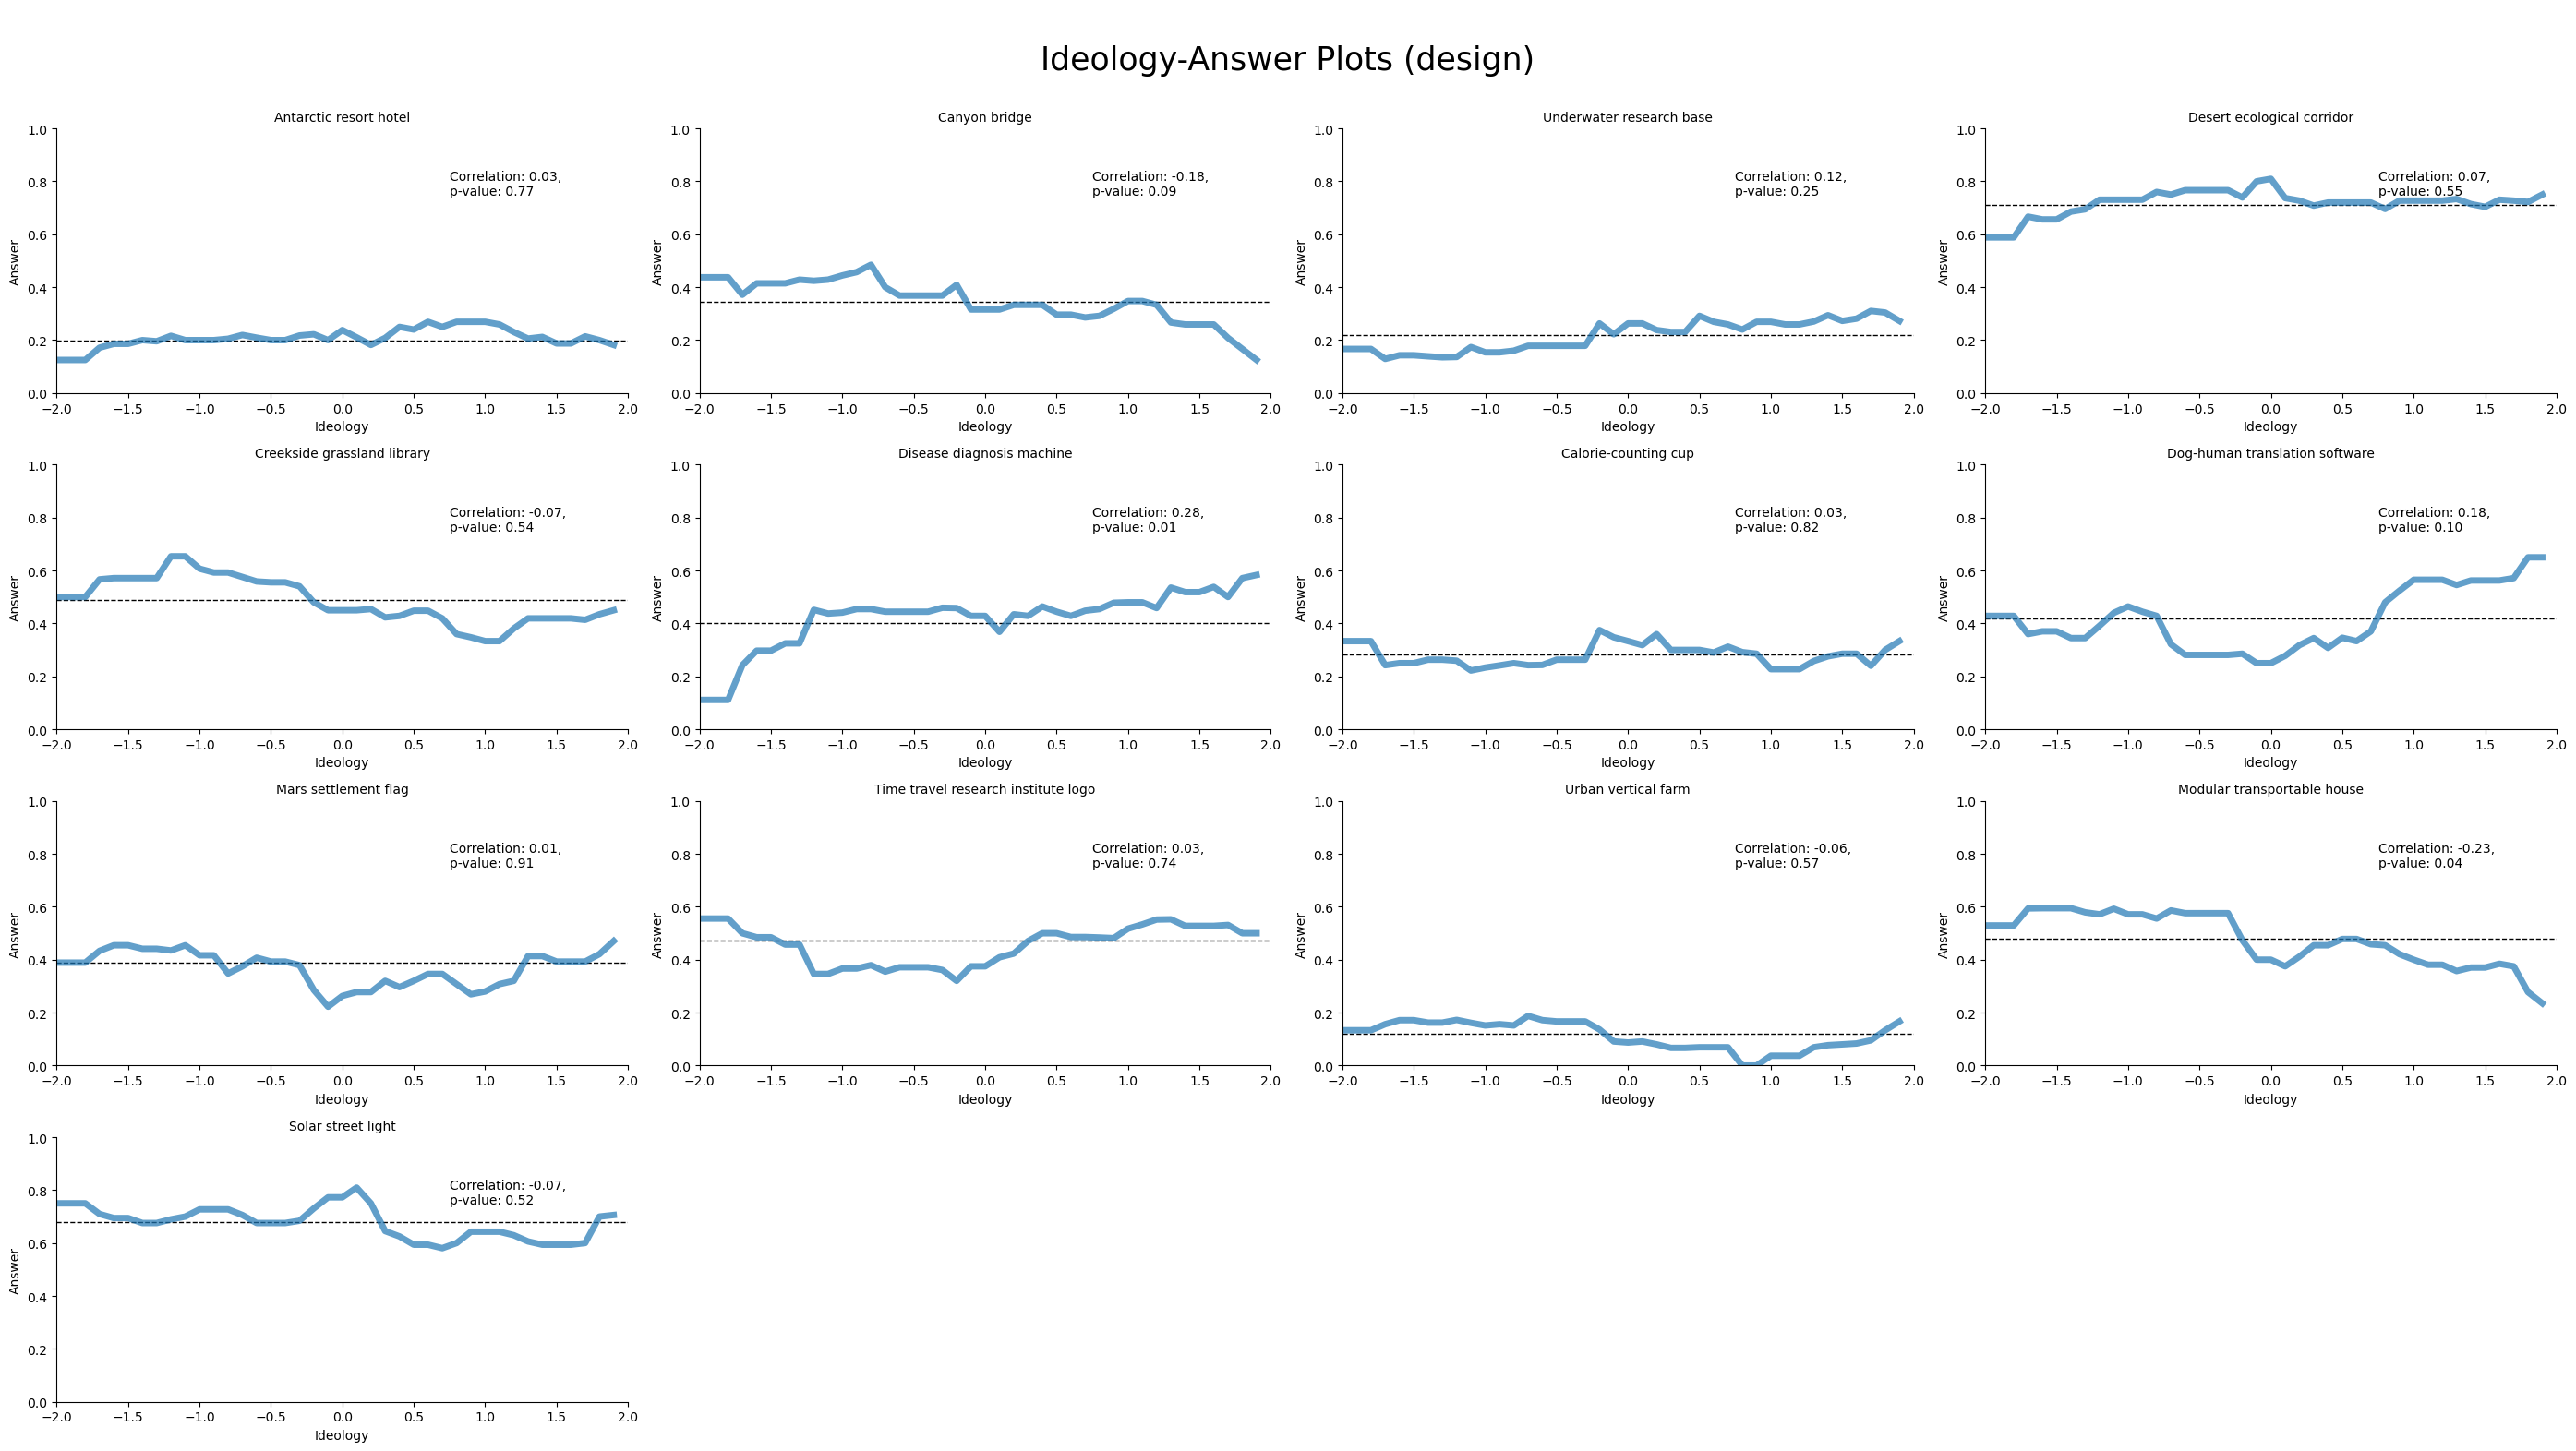

In [30]:
import textwrap

for question_type in phase_2_statements.keys():
    fig, axes = plt.subplots(4, 4, figsize=(28, 16))
    fig.suptitle(f"\nIdeology-Answer Plots ({question_type})\n", fontsize=25)
    for index in range(16):
        ax = axes[index // 4][index % 4]
        if index < len(phase_2_statements[question_type]):
            question_info = phase_2_statements[question_type][index]
            ax.set(
                ylim=(0, 1),
                xlim=(-2, 2),
                xlabel="Ideology",
                ylabel="Answer",
            )
            title = textwrap.fill(question_info["summary"], 70)
            ax.set_title(title, fontsize=10)
            x = df_each.loc[question_type, index]["ideology"]
            y = df_each.loc[question_type, index]["answer"]
            answer_avg = y.mean()
            ax.axhline(answer_avg, color="black", linestyle="--", linewidth=1)
            correlation = pearsonr(x, y)[0], pearsonr(x, y)[1]
            ax.text(0.75, 0.75, f"Correlation: {correlation[0]:.2f}, \np-value: {correlation[1]:.2f}", fontsize=10)
            average, low, high = utils.sliding_average(x, y)
            ax.plot(average.index, average.values, lw=5, alpha=0.7)
        else:
            ax.axis("off")

    utils.savefig(fig, f"visualization/{get_datetime_str()}-pilot_2-{question_type}.jpg", dpi=1000)